# Задача 3. Метод наименьших квадратов.

Пусть физический закон описывается зависимостью некоторого измеряемого значения y(x, a) от времени и координаты x при параметрах a:
$$
y(t, a) = a_2 sin(t) + a_1 t + a_0
$$
Дан набор координат t размера m. ($t = \{0, \frac{10}{m}, \frac{20}{m}, \dots, \frac{(m-1)10}{m}\}$ значения распределены равномерно). Пусть $m = 200$.
Для каждого момента времени $t$ сгенерируйте соответствующее значение $y^t$ при некоторых параметрах $ a_0^t, a_1^t, a_2^t$. Отразите выбранные параметры в отчете.

Существует задача дать оценку параметрам $\overrightarrow{a}$ по результатам физических измерений значений $y^s$. Пусть результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи (случайность подчиняется нормальному закону распределения $\mathcal{N}(0, \sigma)$). Сгенерируйте набор возможных $y^s$. Отразите в отчете выбранное значение $\sigma$.

Для каждого набора параметров $a$ определим $m$ невязок:

$$
\delta_i = y_i^s - y(t_i, a)
$$


__Задача__
По сгенерированному набору точек $(t_i, y_i^s)$ дайте оценку параметрам закона с учетом знания общей формулы тремя различными способами:
1. Пусть параметры $a_2$ будут такими, что сумма квадратов невязок будет минимальна.
2. Пусть параметры параметры $a_1$ будут такими, что сумма абсолютных значений невязок будет минимальна.
3. Пусть параметры параметры $a_{\infty}$ будут такими, что максимальное абсолютное значение невязки будет минимально.


- Постройте в одной координатной плоскости графики $у(t, a), у(t,a_1), у(t, a_2), у(t, a_{\infty})$. 
- Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении $\sigma$?
- Скорректируйте $y_0^s$ и $y_{m-1}^s$ пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

###  Решение:

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format="retina"
sns.set(style='darkgrid', font_scale=1.4,palette='Set2')
np.random.seed(42)
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

Выберем параметры $a_0 = 5, a_1=11, a_2= 13, \sigma=4$.

In [2]:
M=200
a_0, a_1, a_2 = 5, 11, 13
a_true=np.array([5, 11, 13])
SIGMA = 4
SAMPLE_COLOR=sns.color_palette("Set2")[2]

In [3]:
time = np.arange(M) * 10 / M
y_true = a_2 * np.sin(time) + a_1 * time + a_0
y_sample = y_true + sps.norm(scale=SIGMA).rvs(M)

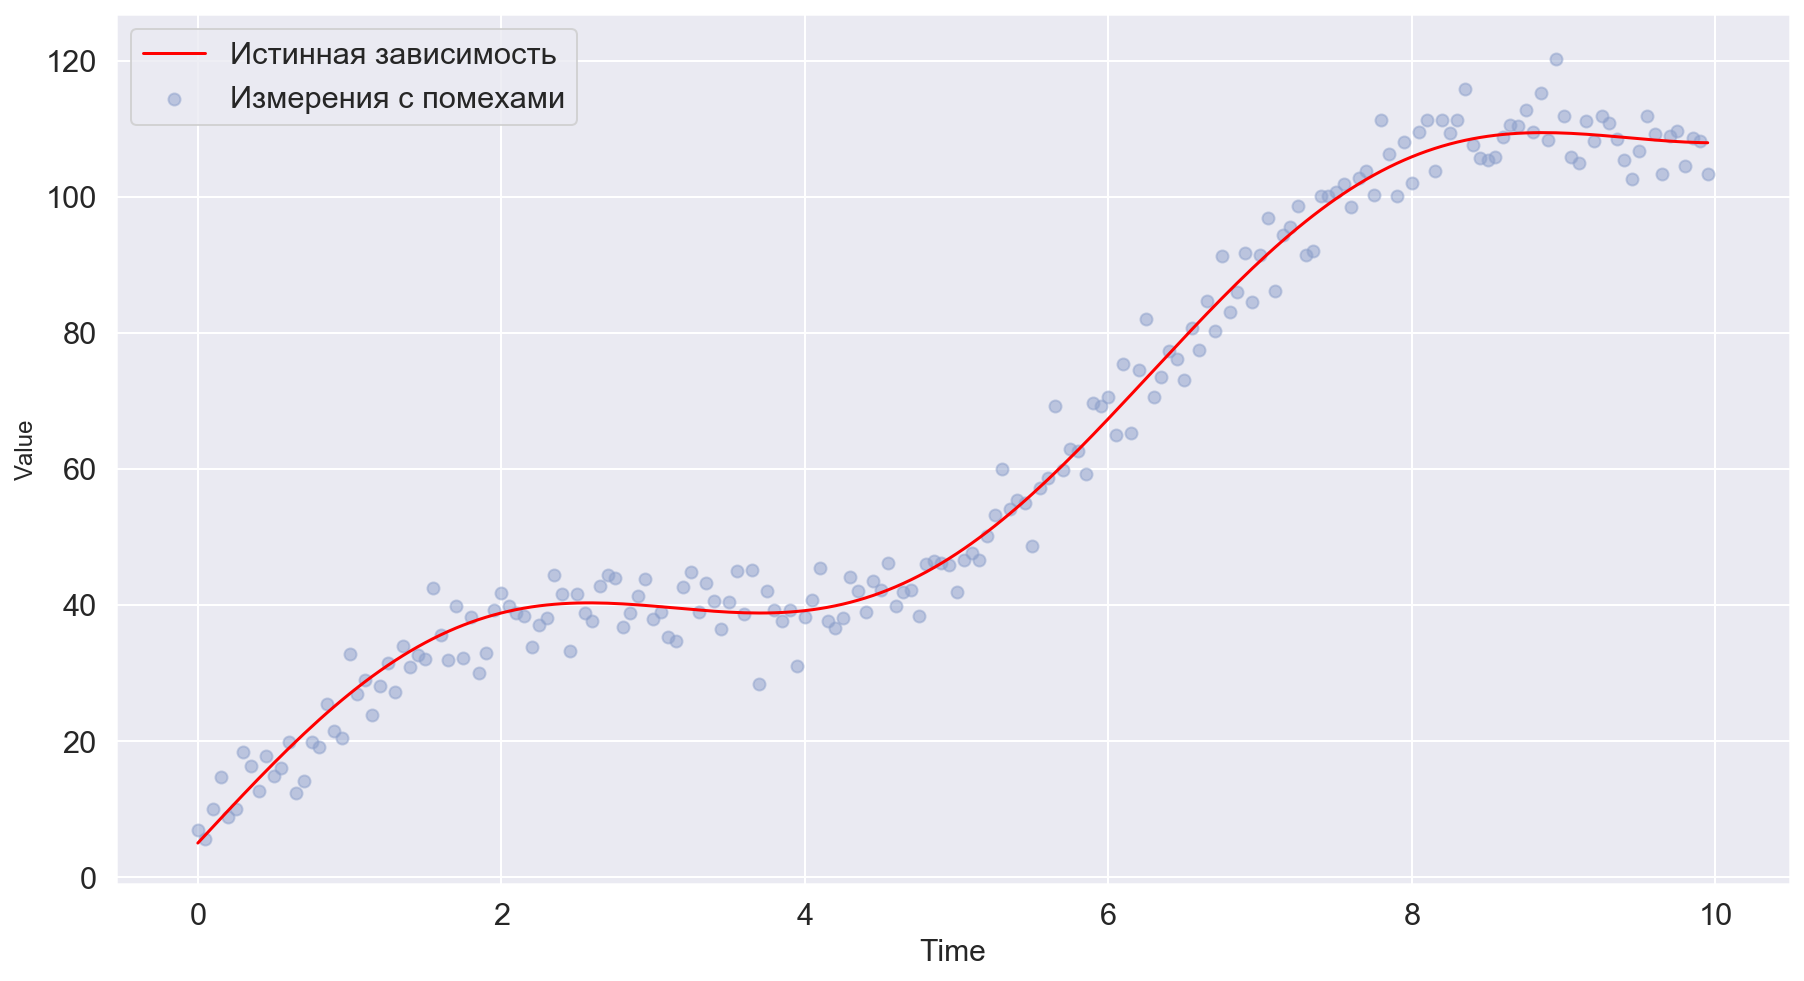

In [4]:
fig, axis = plt.subplots(figsize=(15, 8))

plt.plot(time, y_true, label='Истинная зависимость', color='r')
plt.scatter(time, y_sample, label='Измерения с помехами', color=SAMPLE_COLOR, alpha=0.5)
axis.set_xlabel('Time', fontsize=15)
axis.set_ylabel('Value', fontsize=12)
axis.legend()
plt.show()

### Часть 1. Метод наименьших квадратов.

Для минимизации суммы квадратов невязок подойдет метод наименьших квадратов. Пусть 
$$
X\hat{a}= y
$$
тогда 

$$
\hat{a}= (X^TX)^{-1}X^Ty
$$

In [5]:
def get_task_coef_matrix() -> np.array:
    X = np.zeros((M, 3))
    X[:, 0] = np.sin(time)
    X[:, 1] = time
    X[:, 2] = 1
    return X
def least_squares(y_sample: np.array):
    X = get_task_coef_matrix()
    return np.linalg.inv(X.T @ X) @ X.T @ y_sample

In [6]:
ls_a = least_squares(y_sample)
y_pred_1 = ls_a[0] * np.sin(time) + ls_a[1] * time + ls_a[2]
ls_a

array([12.89453132, 11.09009916,  4.40820868])

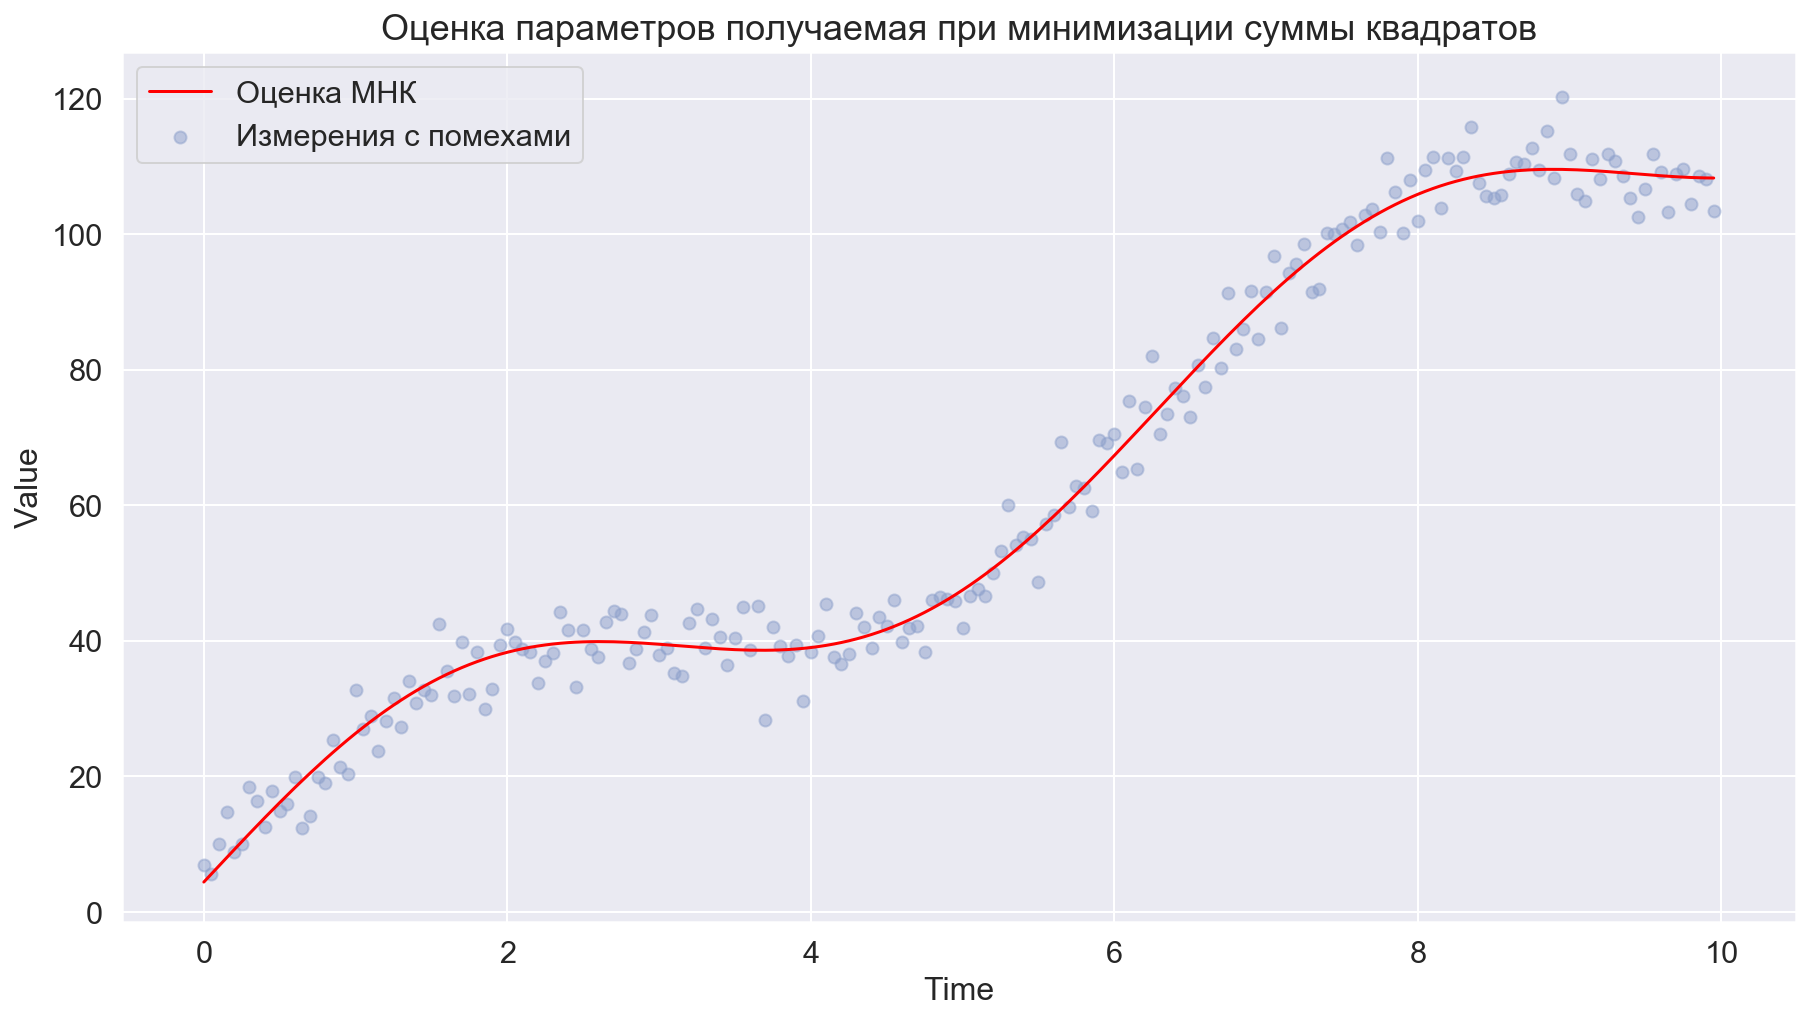

In [7]:
fig, axis = plt.subplots(figsize=(15, 8))
plt.title('Оценка параметров получаемая при минимизации суммы квадратов', fontsize=18)

plt.plot(time, y_pred_1, label='Оценка МНК', color='r')
plt.scatter(time, y_sample, label='Измерения с помехами', color=SAMPLE_COLOR, alpha=0.5)

axis.set_xlabel('Time', fontsize=16)
axis.set_ylabel('Value', fontsize=16)
axis.legend()
plt.show()

### Часть 2.  Минимизация модулей невязок.

Хотим 
$$
\sum_{i=1}^M |a_2 \sin t_i + a_1 t_i + a_0 - y_i^s | \to \min
$$ 
или что то же самое

$$
\forall i: a_2 \sin t_i + a_1 t_i + a_0 - y_i^s \in [-x_i, +x_i]; ~~\sum_{i=1}^M x_i \to \min 
$$

Тогда это сводится к задаче ЛП:

$$ 
<x,c> \to min \\
\left(\begin{array}{cc}  
   -E & A\\  
   -E & -A 
\end{array}\right) x 
\leq
\left(\begin{array}{c}  
   y \\  
   -y  
\end{array}\right)
$$

Где
$$
x = (x_1, ..., x_m, a_0, a_1, a_2) \\
c = (1, ..., 1, 0, 0, 0)
$$

Матрица $A$ - матрица коэффициентов при параметрах в нашей задаче. 

Для решения воспользуемся симплекс-методом.


In [8]:
from scipy.optimize import linprog

In [9]:
def linprog_solver(c, A, b):
    return linprog(c, A_ub=A, b_ub=b, bounds=[(-np.inf, np.inf)] * A.shape[1], 
            options=dict(tol=1e-8, maxiter=10 ** 6), )

def least_modules(y_sample: np.array):
    A = get_task_coef_matrix()
    eye = np.eye(M)
    B = np.bmat([[-eye, A],
                 [-eye, -A]])

    b = np.matrix(y_sample).T
    b = np.bmat([[b], [-b]])
    c = np.array(np.bmat([[np.ones(M), np.zeros(3)]]).flat)
    res = linprog_solver(c, B, b)
    return res.x[-3:]

In [10]:
lm_a = least_modules(y_sample)
y_pred_2 = lm_a[0] * np.sin(time) + lm_a[1] * time + lm_a[2]
lm_a

array([13.45396277, 11.20285444,  3.93262715])

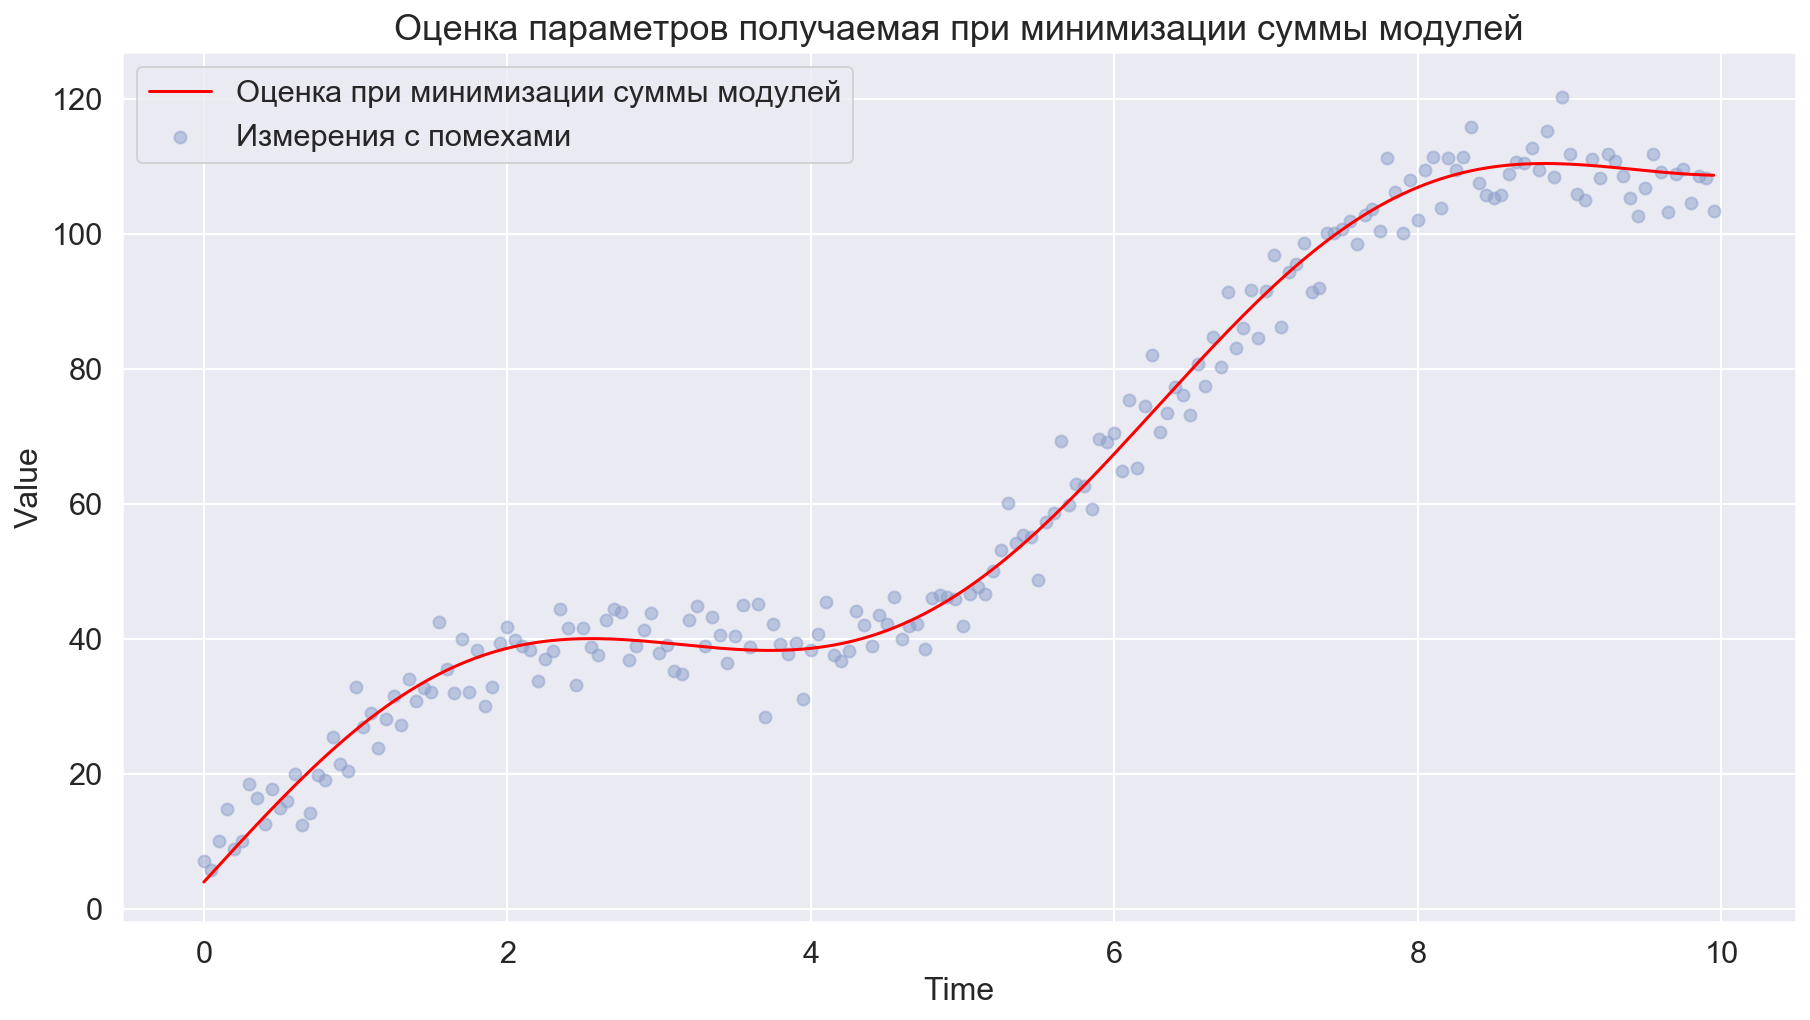

In [11]:
fig, axis = plt.subplots(figsize=(15, 8))
plt.title('Оценка параметров получаемая при минимизации суммы модулей', fontsize=18)


plt.plot(time, y_pred_2, label='Оценка при минимизации суммы модулей', color='r')
plt.scatter(time, y_sample, label='Измерения с помехами', alpha=0.5,color=SAMPLE_COLOR)

axis.set_xlabel('Time', fontsize=16)
axis.set_ylabel('Value', fontsize=16)
axis.legend()
plt.show()

### Часть 3. Минимизация максимальной по модулю невязки.

Хотим 
$$
\sum_{i=1}^M |a_2 \sin t_i + a_1 t_i + a_0 - y_i^s | \to \min
$$ 
или что то же самое

$$
\forall i: a_2 \sin t_i + a_1 t_i + a_0 - y_i^s \in [-x_i, +x_i]; ~~\sum_{i=1}^M x_i \to \min 
$$

Тогда это сводится к задаче ЛП:

$$ 
<x,c> \to min \\
\left[\begin{array}{cc}  
    \left(\begin{array}{c}  
       -1\\
       \vdots \\
       -1 
    \end{array}\right) & A\\  
    \left(\begin{array}{c}  
       -1\\
       \vdots \\
       -1 
    \end{array}\right) & -A\\ 
\end{array}\right] x 
\leq
\left(\begin{array}{c}  
   y \\  
   -y  
\end{array}\right)
$$

Где
$$
x = (x_0, a_0, a_1, a_2) \\
c = (1, 0, 0, 0)
$$

Матрица $A$ - матрица коэффициентов при параметрах в нашей задаче. 

In [12]:
def least_abs_max(y_sample: np.array):
    A = get_task_coef_matrix()
    eye = np.matrix(np.ones(M)).T
    B = np.bmat([[-eye, A], [-eye, -A]])

    b = np.matrix(y_sample).T
    b = np.bmat([[b], [-b]])
    c = np.array(np.bmat([[np.ones(1), np.zeros(3)]]).flat)

    res = linprog_solver(c, B, b)
    return res.x[-3:]

In [13]:
lam_a = least_abs_max(y_sample)
y_pred_3 = lam_a[0] * np.sin(time) + lam_a[1] * time + lam_a[2]
lam_a

array([13.42456238, 11.73136525,  1.50594578])

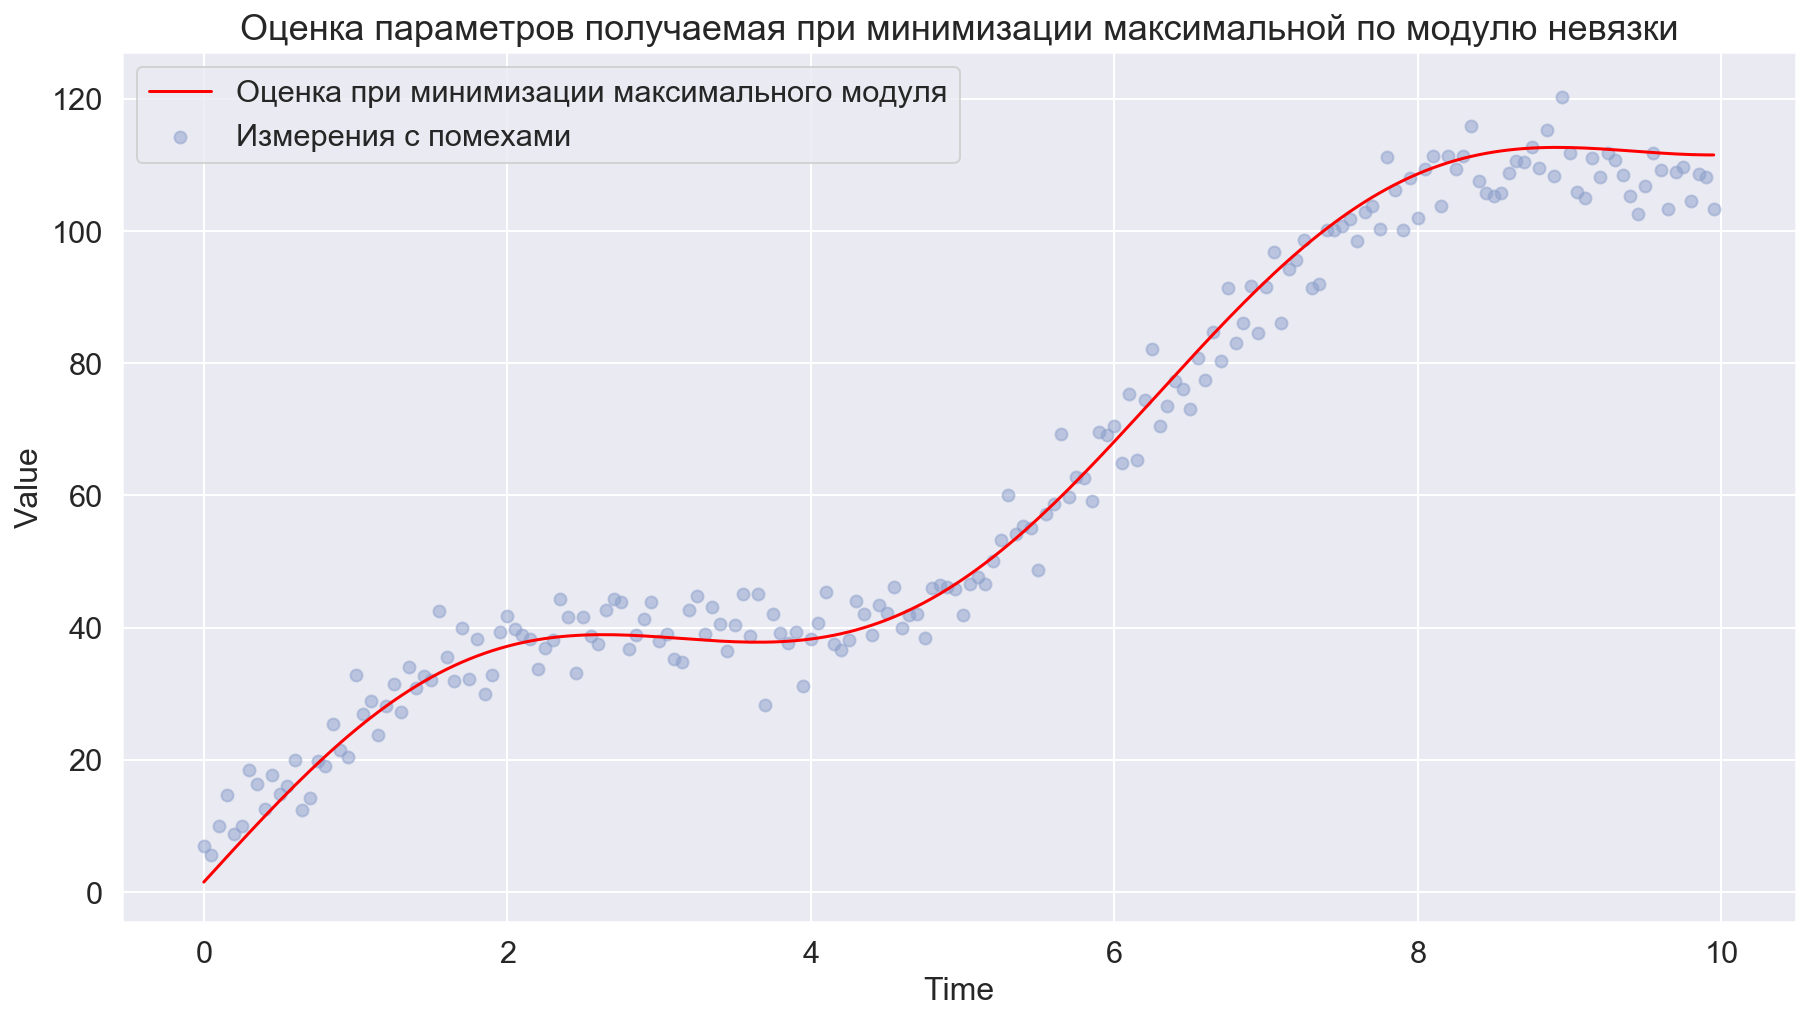

In [14]:
fig, axis = plt.subplots(figsize=(15, 8))
plt.title('Оценка параметров получаемая при минимизации максимальной по модулю невязки', fontsize=18)


plt.plot(time, y_pred_3, label='Оценка при минимизации максимального модуля', color='r')
plt.scatter(time, y_sample, label='Измерения с помехами', alpha=0.5,color=SAMPLE_COLOR)

axis.set_xlabel('Time', fontsize=16)
axis.set_ylabel('Value', fontsize=16)
axis.legend()
plt.show()

Построим в одной координатной плоскости графики $у(t, a), у(t,a_1), у(t, a_2), у(t, a_{\infty})$. 

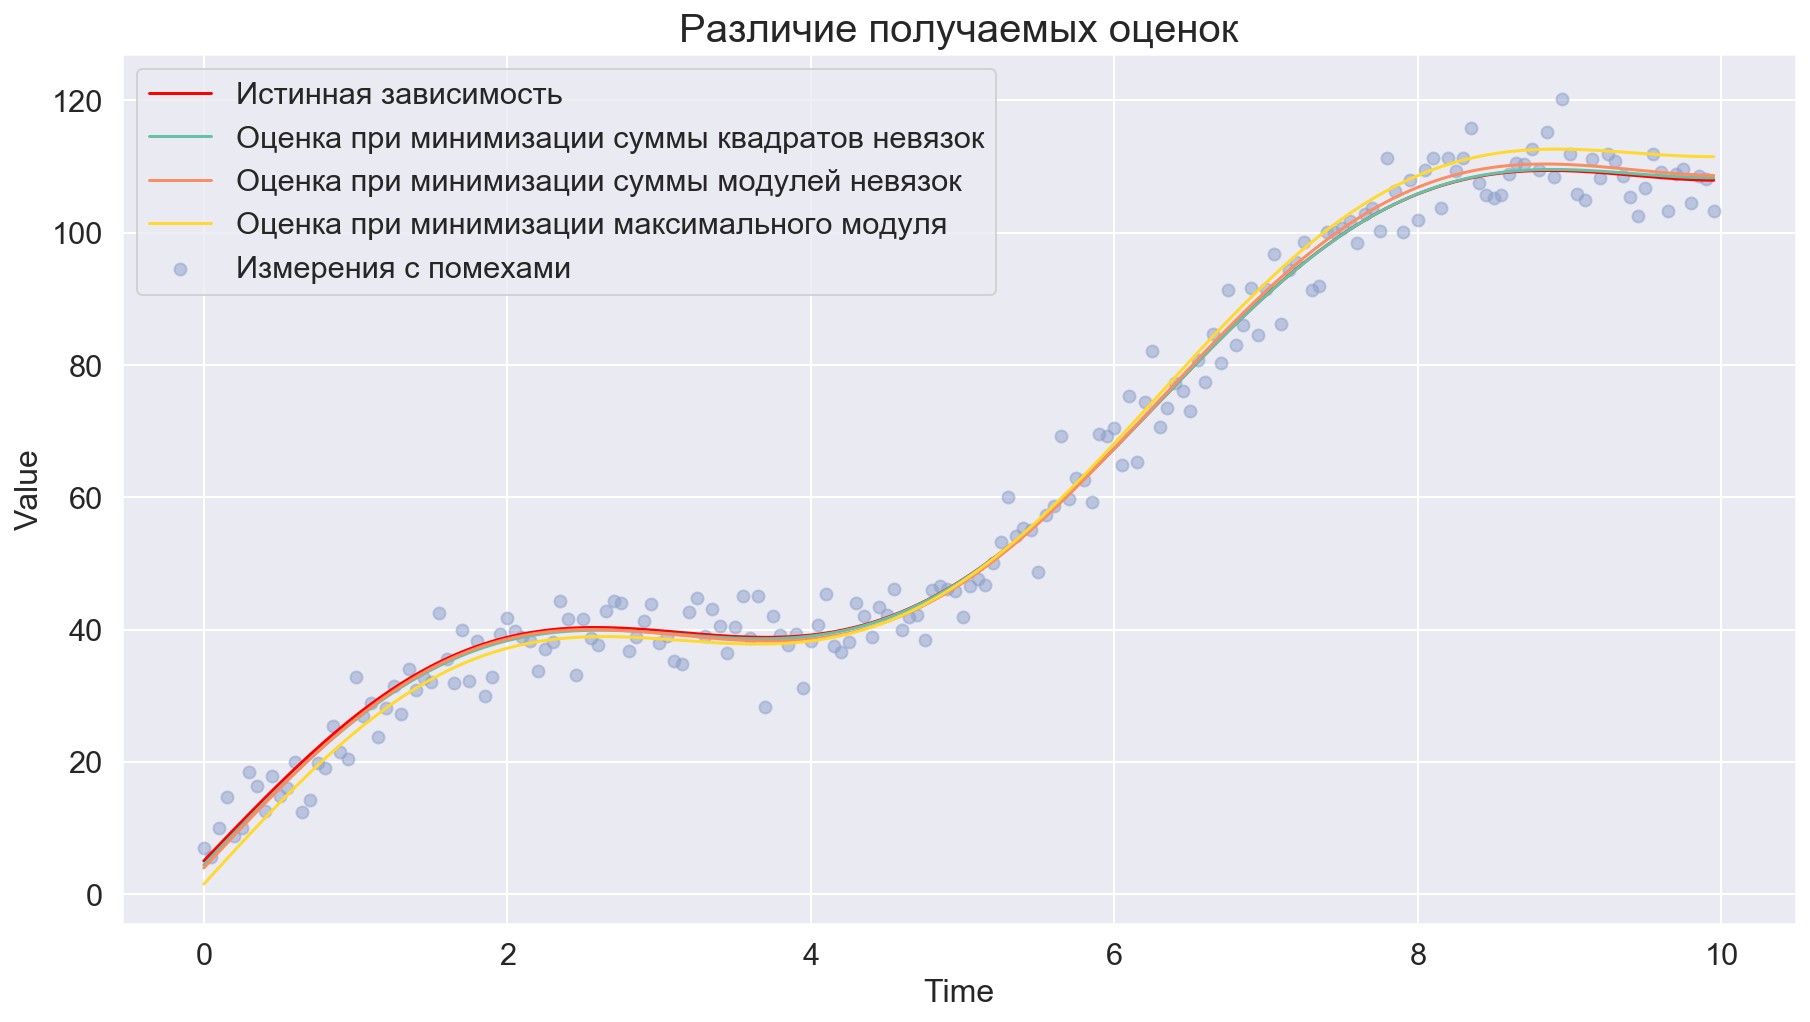

In [15]:
fig, axis = plt.subplots(figsize=(15, 8))
plt.title('Различие получаемых оценок', fontsize=20)

plt.plot(time, y_true, label='Истинная зависимость', color='r')
plt.plot(time, y_pred_1, label='Оценка при минимизации суммы квадратов невязок')
plt.scatter(time, y_sample, label='Измерения с помехами', alpha=0.5,color=SAMPLE_COLOR)
plt.plot(time, y_pred_2, label='Оценка при минимизации суммы модулей невязок')
plt.plot(time, y_pred_3, label='Оценка при минимизации максимального модуля', color=sns.color_palette("Set2")[5])


axis.set_xlabel('Time', fontsize=16)
axis.set_ylabel('Value', fontsize=16)
axis.legend()
plt.show()

### Часть 4. Зависимость модуля разности истинных и предсказываемых параметров от $\sigma$

Нарисуем три графика: для оценки каждого типа на одной координатой оси будем смотреть за тем как изменяется модуль разности предсказываемого и истинного значения параметров $a_0, a_1, a_2$.

In [16]:
a = np.array([1,2])
b = np.array([3,4])
c = np.array([a, b])
c[0]

array([1, 2])

In [17]:
from typing import Callable

In [18]:
def draw_estimation_sigma_relation(estimator: Callable[[np.array], np.array], 
                                   y_true: np.array, title: str):
    fig, axis = plt.subplots(figsize=(15, 8))
    plt.title(title, fontsize=20)
    sigma_grid = np.linspace(1, 9, 100)
    a_2 = np.zeros(len(sigma_grid))
    a_1 = np.zeros(len(sigma_grid))
    a_0 = np.zeros(len(sigma_grid))
    
    for i, sigma in enumerate(sigma_grid):
        y_sample = y_true + sps.norm(scale=sigma).rvs(M)
        a_2[i], a_1[i], a_0[i] = estimator(y_sample)
        
    params = np.array([a_0, a_1, a_2])
    for i in range(3):
        diff = np.absolute(params[i] - a_true[i])
        plt.plot(sigma_grid, diff, label=(fr'Разница для параметра $a_{i}$'))
        
    
    axis.set_xlabel(r'$Значение \ \sigma$', fontsize=16)
    axis.set_ylabel('Разница', fontsize=16)
    plt.legend()
    plt.show()

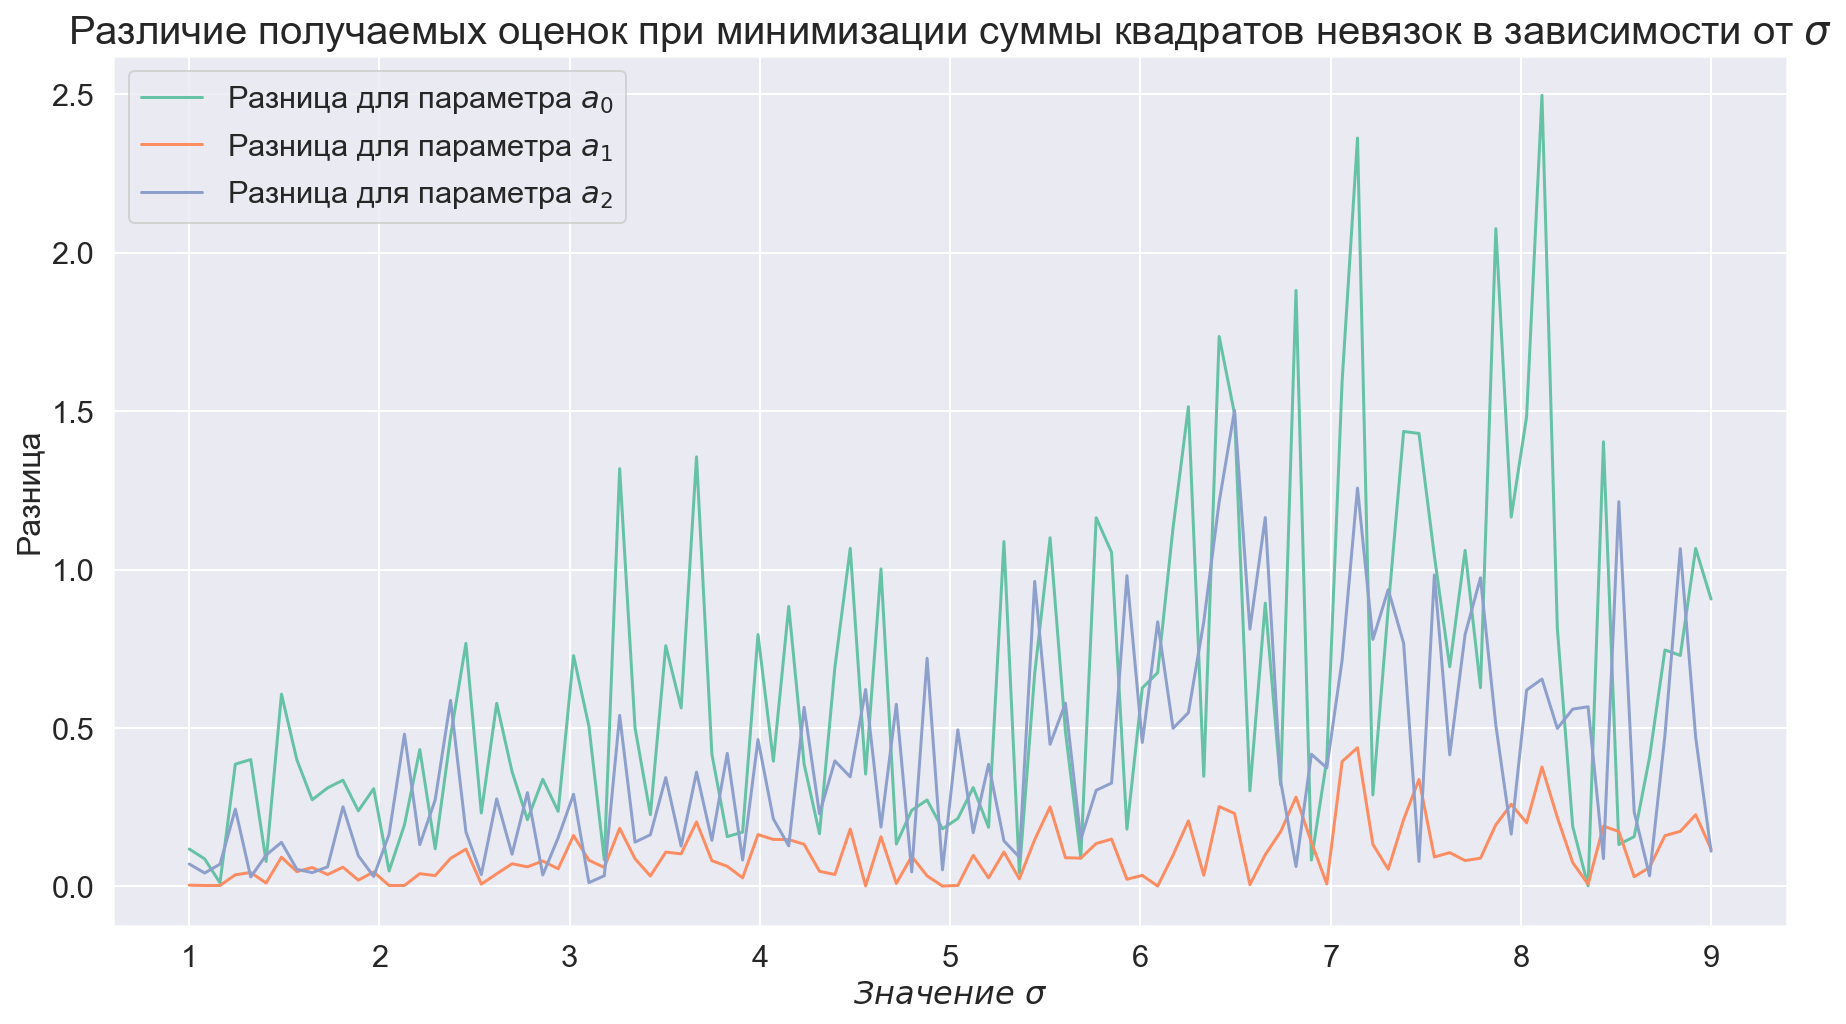

In [19]:
draw_estimation_sigma_relation(
    least_squares, 
    y_true, 
    title=r'Различие получаемых оценок при минимизации суммы квадратов невязок в зависимости от $\sigma$')

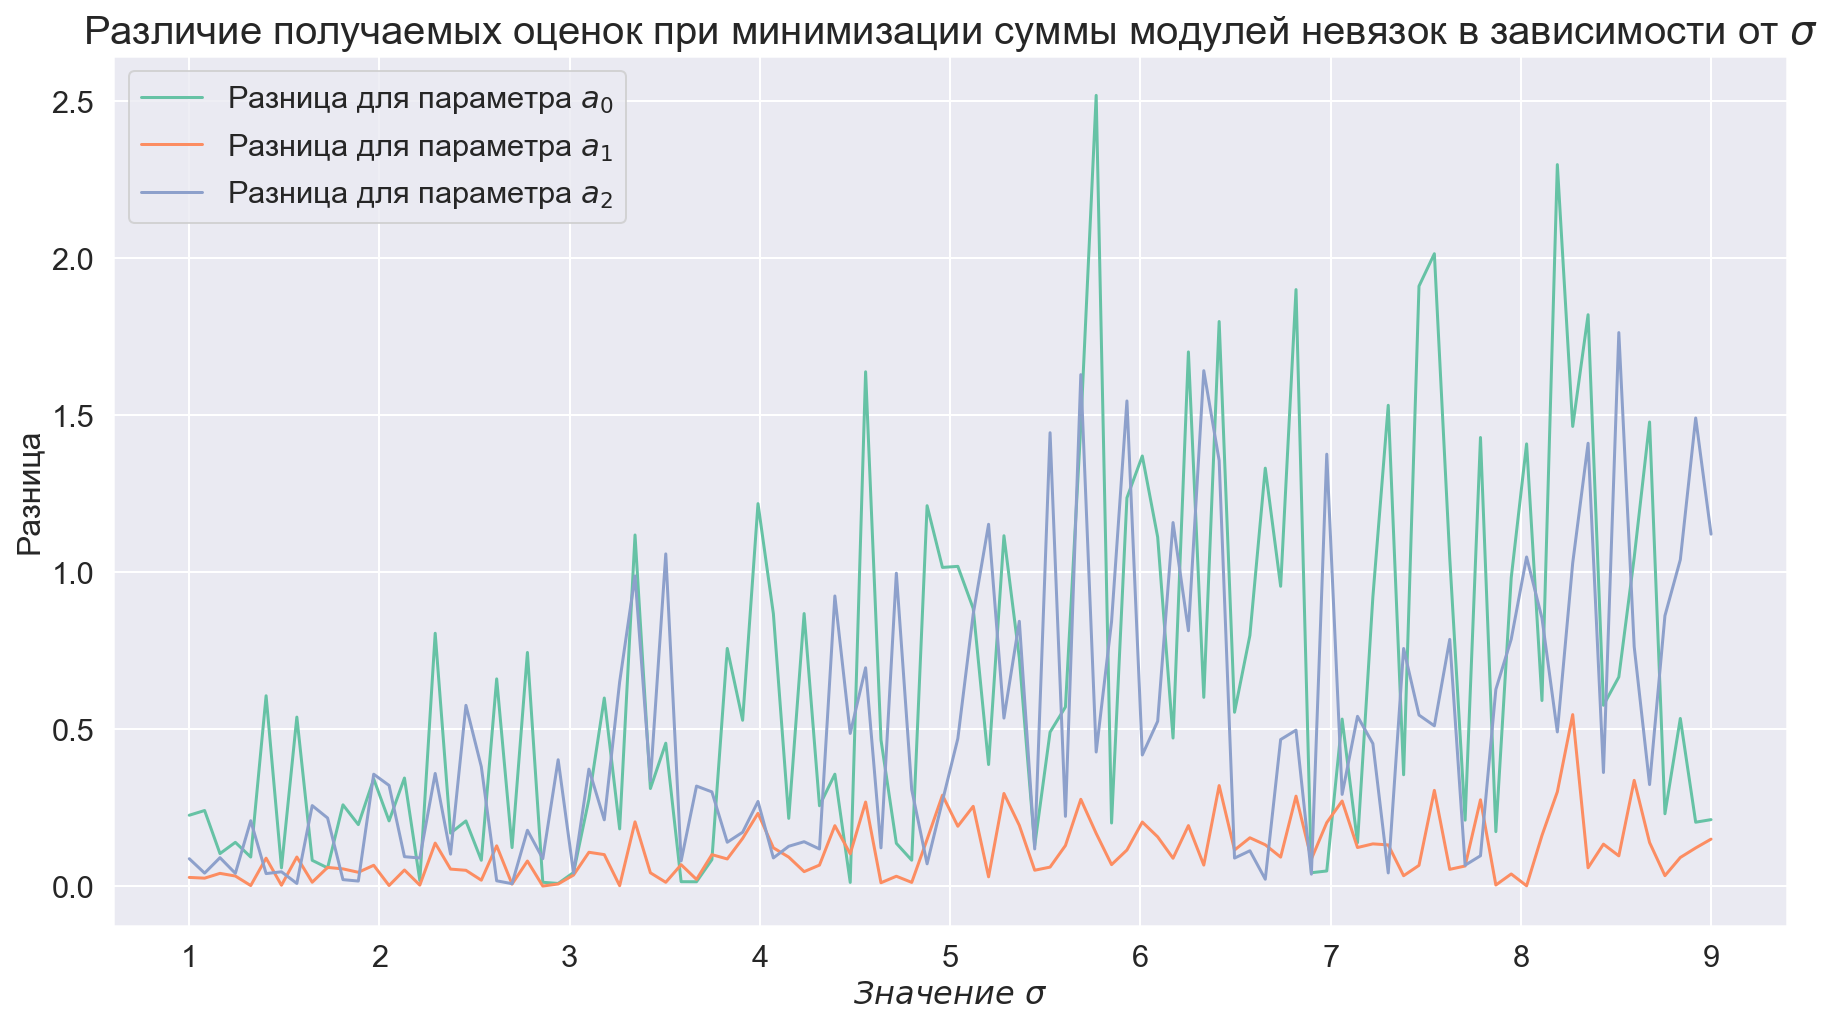

In [20]:
draw_estimation_sigma_relation(
    least_modules, 
    y_true, 
    title=r'Различие получаемых оценок при минимизации суммы модулей невязок в зависимости от $\sigma$')

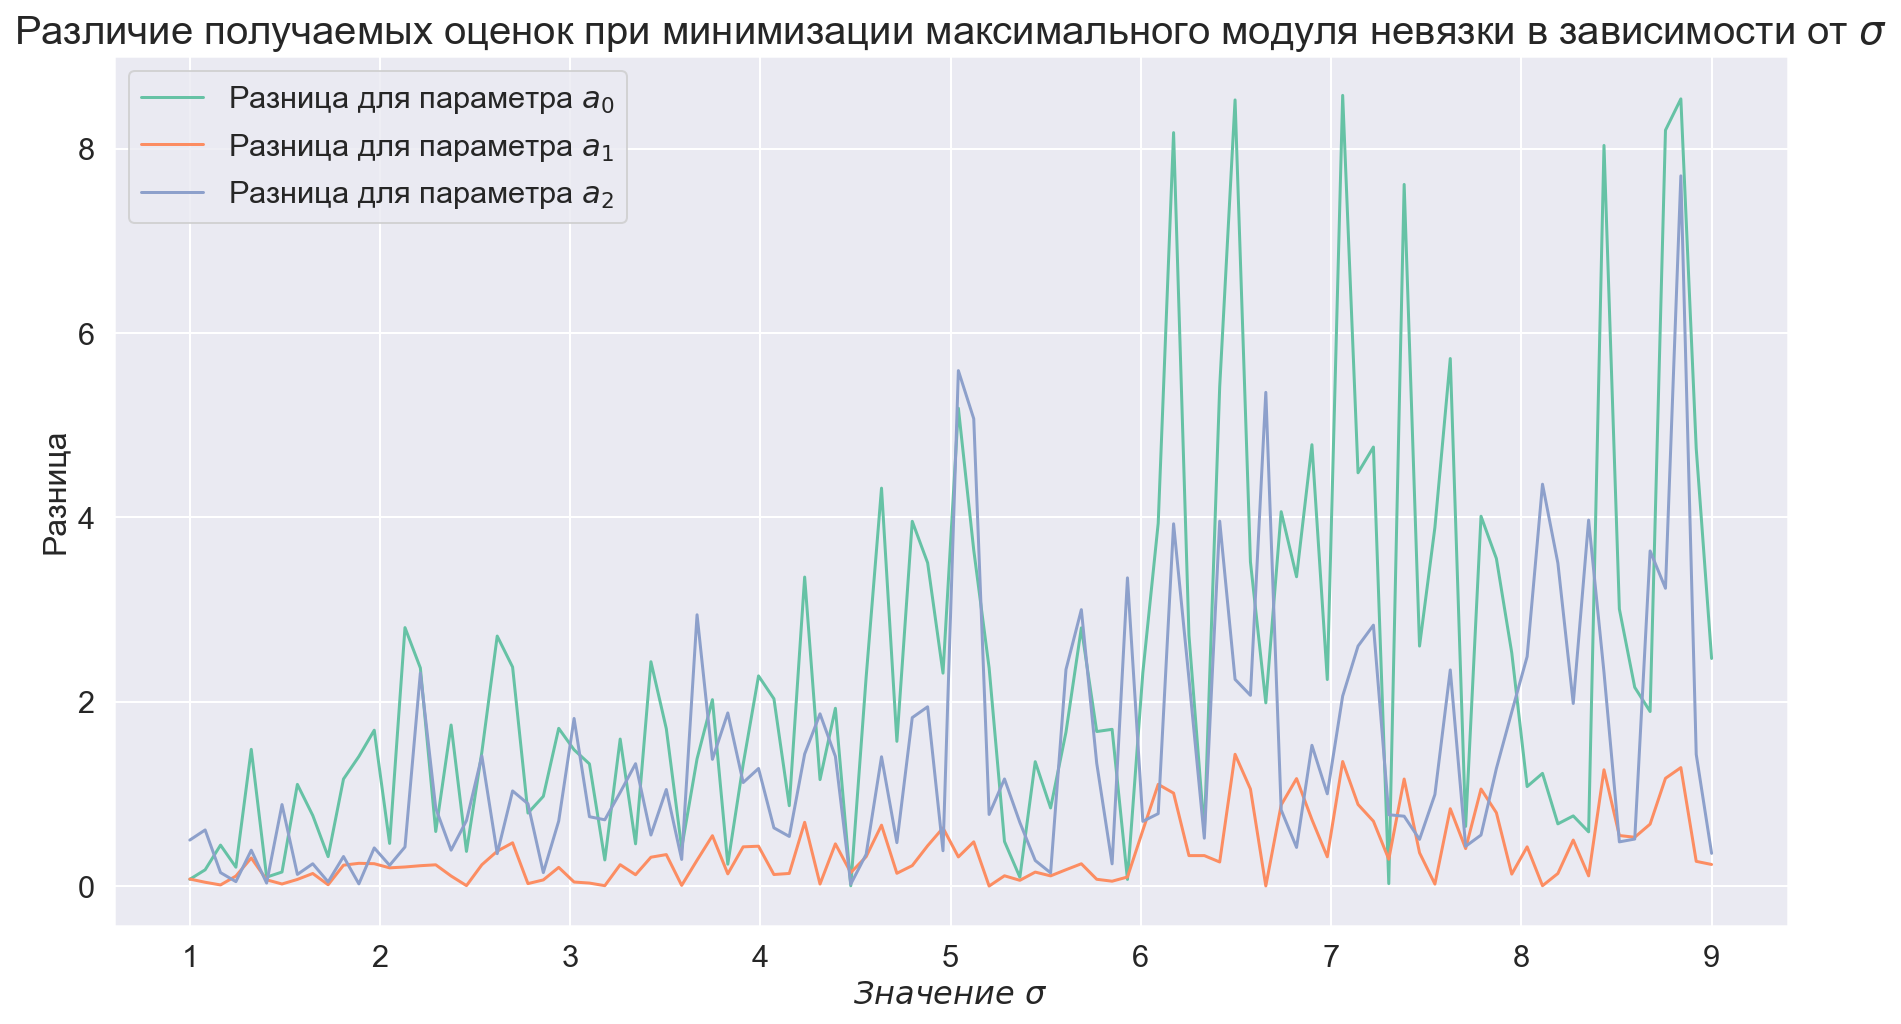

In [21]:
draw_estimation_sigma_relation(
    least_abs_max, 
    y_true, 
    title=r'Различие получаемых оценок при минимизации максимального модуля невязки в зависимости от $\sigma$')

Из графиков видно, что точнее всего причем в каждом из методов оценивается параметр $a_1$, хуже всего - $a_0$. Из трех методов самым лучшим если судить по модулю отклонению от реального значения оказался МНК. Хуже всего метод при котором минимизируем максимальный модуль невязки, при $\sigma \in [1, 9]$ он может давать ошибку порядка 8-10.

### Часть 5. Исследуем оценки на устойчивость к выбросам.

Скорректируйте $y_0^s$ и $y_{m-1}^s$ пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

In [22]:
y_sample_outliers = y_sample.copy()
y_sample_outliers[0] += 50
y_sample_outliers[-1] -= 50


ls_a = least_squares(y_sample_outliers)
lm_a = least_modules(y_sample_outliers)
lam_a = least_abs_max(y_sample_outliers)
y_pred_1_ol = ls_a[0] * np.sin(time) + ls_a[1] * time + ls_a[2]
y_pred_2_ol = lm_a[0] * np.sin(time) + lm_a[1] * time + lm_a[2]
y_pred_3_ol = lam_a[0] * np.sin(time) + lam_a[1] * time + lam_a[2]

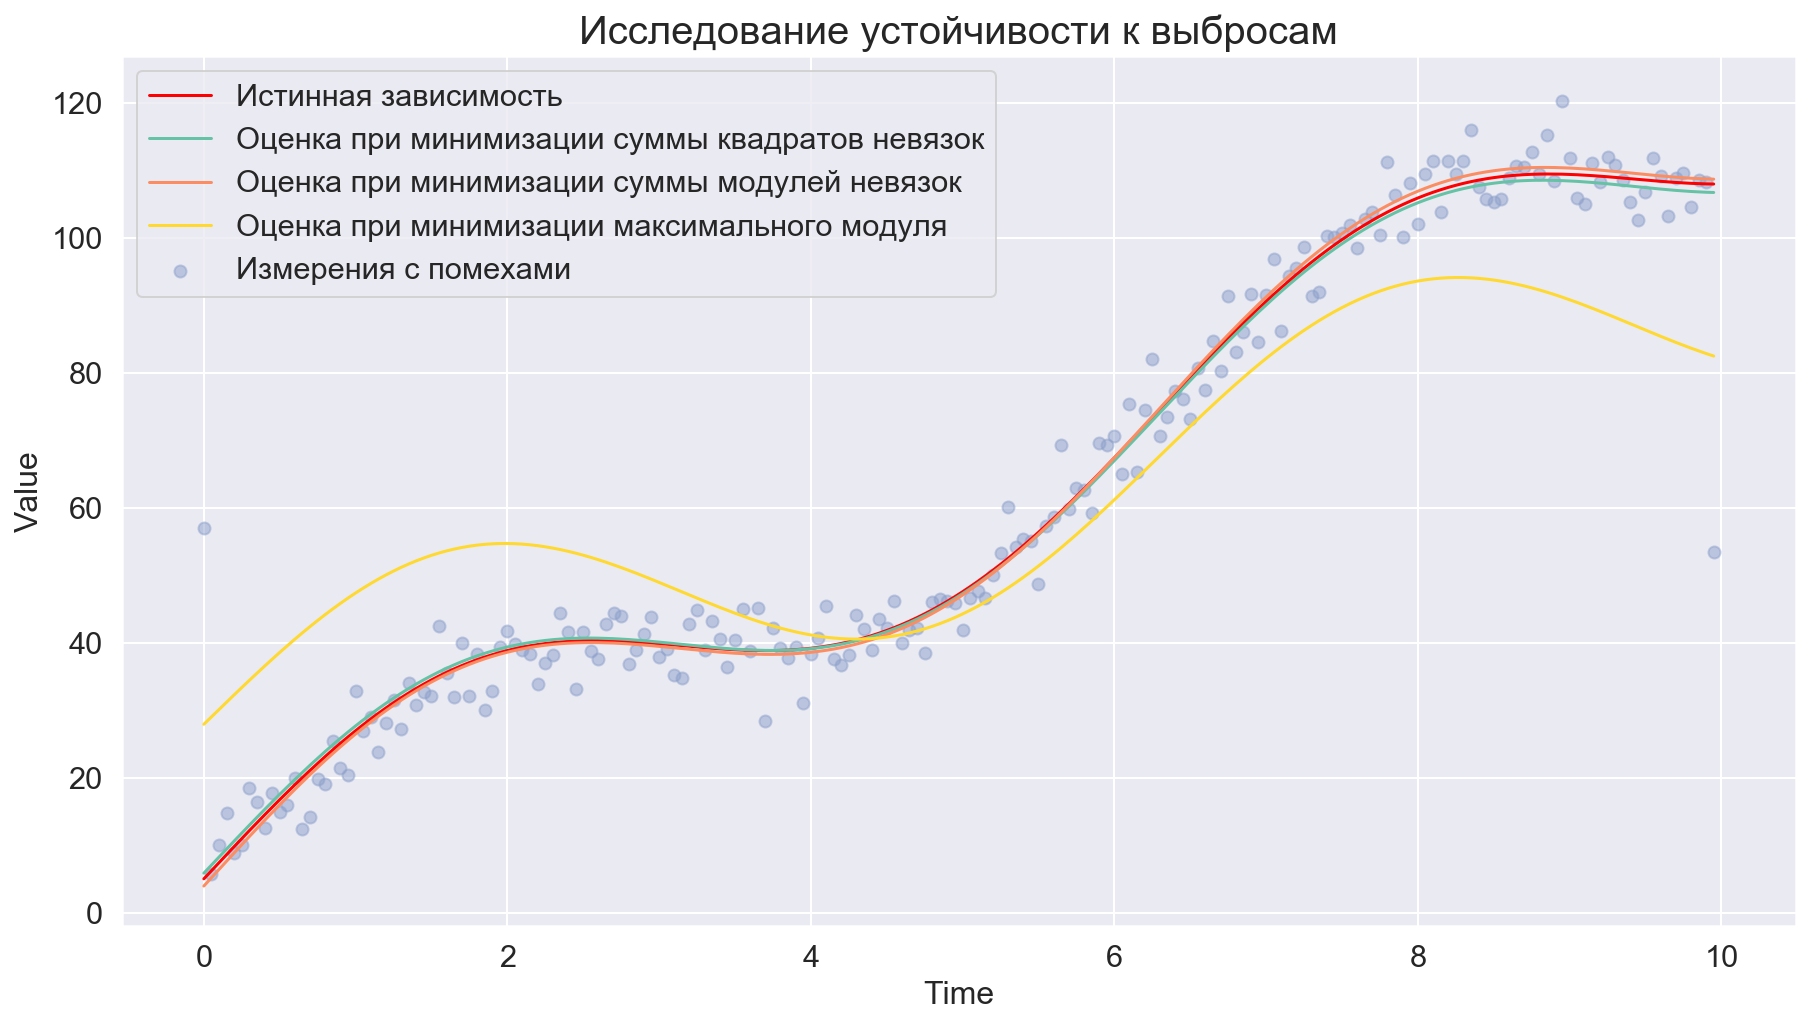

In [23]:
fig, axis = plt.subplots(figsize=(15, 8))
plt.title('Исследование устойчивости к выбросам', fontsize=20)

plt.plot(time, y_true, label='Истинная зависимость', color='r')
plt.plot(time, y_pred_1_ol, label='Оценка при минимизации суммы квадратов невязок')
plt.scatter(time, y_sample_outliers, label='Измерения с помехами', alpha=0.5,color=SAMPLE_COLOR)
plt.plot(time, y_pred_2_ol, label='Оценка при минимизации суммы модулей невязок')
plt.plot(time, y_pred_3_ol, label='Оценка при минимизации максимального модуля', color=sns.color_palette("Set2")[5])


axis.set_xlabel('Time', fontsize=16)
axis.set_ylabel('Value', fontsize=16)
axis.legend()
plt.show()

Как мы видим методы минимизирующие сумму квадратов и суммы модулей - устойчивы к выбросам, а метод минимизирующий максимальный модуль невязки - нет.